<a href="https://colab.research.google.com/github/fareesah28/INM705-CW/blob/main/MARIUMCOLAB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
!unzip "/content/drive/MyDrive/data_trimmed_clean.zip" -d /content/

Streaming output truncated to the last 5000 lines.
  inflating: /content/data_trimmed/Train/Shooting/Shooting042_x264_1030.png  
 extracting: /content/data_trimmed/Train/Shooting/Shooting020_x264_2680.png  
  inflating: /content/data_trimmed/Train/Shooting/Shooting029_x264_1260.png  
  inflating: /content/data_trimmed/Train/Shooting/Shooting009_x264_2690.png  
 extracting: /content/data_trimmed/Train/Shooting/Shooting014_x264_2740.png  
  inflating: /content/data_trimmed/Train/Shooting/Shooting006_x264_4510.png  
  inflating: /content/data_trimmed/Train/Shooting/Shooting006_x264_11010.png  
  inflating: /content/data_trimmed/Train/Shooting/Shooting006_x264_9020.png  
  inflating: /content/data_trimmed/Train/Shooting/Shooting005_x264_1860.png  
 extracting: /content/data_trimmed/Train/Shooting/Shooting052_x264_4560.png  
  inflating: /content/data_trimmed/Train/Shooting/Shooting009_x264_130.png  
 extracting: /content/data_trimmed/Train/Shooting/Shooting027_x264_140.png  
  inflating: /

In [ ]:
# # ONLY USED FOR TESTING AND DEBUGGING - for final model we will use the whole dataset

# import os
# import shutil

# def create_debug_subset_sequential(source_dir, dest_dir, train_limit=4000, test_limit=1500):
#     if os.path.exists(dest_dir):
#         shutil.rmtree(dest_dir)
#     os.makedirs(dest_dir, exist_ok=True)

#     for split, limit in [("Train", train_limit), ("Test", test_limit)]:
#         src_split_path = os.path.join(source_dir, split)
#         dst_split_path = os.path.join(dest_dir, split)
#         os.makedirs(dst_split_path, exist_ok=True)

#         for class_name in os.listdir(src_split_path):
#             class_src = os.path.join(src_split_path, class_name)
#             class_dst = os.path.join(dst_split_path, class_name)
#             os.makedirs(class_dst, exist_ok=True)

#             valid_images = sorted([f for f in os.listdir(class_src) if f.endswith(".png") and not f.startswith("._")])
#             selected_images = valid_images[:limit]

#             for img in selected_images:
#                 shutil.copy(os.path.join(class_src, img), os.path.join(class_dst, img))

# create_debug_subset_sequential("/content/data_trimmed", "/content/data_trimmed_debug", train_limit=4000, test_limit=1500)

# # paths
# train_dir = "/content/data_trimmed_debug/Train"
# test_dir = "/content/data_trimmed_debug/Test"

In [1]:
import os
import shutil
from collections import defaultdict

def extract_video_id(filename):
    """
    Extracts the video ID by removing the frame suffix (assumes last underscore + digits is the frame number).
    For example:
        Normal_Videos_003_x264_0.png → Normal_Videos_003_x264
        Assault_001_frame_010.png → Assault_001
    """
    parts = filename.rsplit("_", 1)
    return parts[0] if len(parts) == 2 else filename.split("_frame")[0]

def restructure_dataset(src_dir, dst_dir):
    os.makedirs(dst_dir, exist_ok=True)

    for class_name in os.listdir(src_dir):
        class_path = os.path.join(src_dir, class_name)
        if not os.path.isdir(class_path):
            continue

        print(f"Processing class: {class_name}")
        video_frame_dict = defaultdict(list)

        for fname in os.listdir(class_path):
            if not fname.endswith('.png'):
                continue

            video_id = extract_video_id(fname)
            video_frame_dict[video_id].append(fname)

        for video_id, frames in video_frame_dict.items():
            video_folder_path = os.path.join(dst_dir, class_name, video_id)
            os.makedirs(video_folder_path, exist_ok=True)

            for frame in frames:
                src = os.path.join(class_path, frame)
                dst = os.path.join(video_folder_path, frame)
                shutil.copy2(src, dst)

    print(f"Done restructuring: {src_dir} → {dst_dir}\n")

train_dir = "/content/data_trimmed/Train"
test_dir = "/content/data_trimmed/Test"

train_dst = "/content/data_trimmed_restructured/Train"
test_dst = "/content/data_trimmed_restructured/Test"

# Run restructuring
restructure_dataset(train_dir, train_dst)
restructure_dataset(test_dir, test_dst)

Processing class: NormalVideos
Processing class: Burglary
Processing class: Explosion
Processing class: Assault
Processing class: Fighting
Processing class: Shooting
Processing class: Arrest
Processing class: Arson
Done restructuring: /content/data_trimmed/Train → /content/data_trimmed_restructured/Train

Processing class: NormalVideos
Processing class: Burglary
Processing class: Explosion
Processing class: Assault
Processing class: Fighting
Processing class: Shooting
Processing class: Arrest
Processing class: Arson
Done restructuring: /content/data_trimmed/Test → /content/data_trimmed_restructured/Test



In [2]:
IMG_HEIGHT = 64
IMG_WIDTH = 64
SEQUENCE_LENGTH = 16  # Pad/truncate each video to this many frames
BATCH_SIZE = 8
CLASS_NAMES = ['Arrest','Arson','Assault','Burglary','Explosion','Fighting','NormalVideos','Shooting']
NUM_CLASSES = len(CLASS_NAMES)

In [3]:
import tensorflow as tf
import numpy as np
import os
from glob import glob
from tensorflow.keras.utils import to_categorical
from PIL import Image

def load_video_frames(video_dir, sequence_length, img_size):
    # Get sorted list of frame paths
    frame_paths = sorted(glob(os.path.join(video_dir, "*.png")))

    frames = []
    for path in frame_paths[:sequence_length]:
        img = Image.open(path).resize(img_size)
        frame = np.array(img).astype("float32") / 255.0  # Normalize to [0, 1]
        frames.append(frame)

    # Pad with zeros if not enough frames
    while len(frames) < sequence_length:
        frames.append(np.zeros((img_size[1], img_size[0], 3), dtype="float32"))

    return np.stack(frames)

def get_video_paths_and_labels(base_dir, class_names):
    video_paths = []
    labels = []

    for class_index, class_name in enumerate(class_names):
        class_path = os.path.join(base_dir, class_name)
        for video_folder in os.listdir(class_path):
            video_path = os.path.join(class_path, video_folder)
            if os.path.isdir(video_path):
                video_paths.append(video_path)
                labels.append(class_index)

    return video_paths, labels

def build_video_dataset(base_dir, sequence_length, img_size, batch_size, class_names, shuffle=True):
    video_paths, labels = get_video_paths_and_labels(base_dir, class_names)

    def generator():
        for video_path, label in zip(video_paths, labels):
            frames = load_video_frames(video_path, sequence_length, img_size)
            yield frames, to_categorical(label, num_classes=len(class_names))

    dataset = tf.data.Dataset.from_generator(
        generator,
        output_signature=(
            tf.TensorSpec(shape=(sequence_length, img_size[1], img_size[0], 3), dtype=tf.float32),
            tf.TensorSpec(shape=(len(class_names),), dtype=tf.float32)
        )
    )

    if shuffle:
        dataset = dataset.shuffle(buffer_size=len(video_paths))

    return dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [4]:
train_dir = "data_trimmed_restructured/Train"
test_dir = "data_trimmed_restructured/Test"
train_dataset = build_video_dataset(
    base_dir=train_dir,
    sequence_length=SEQUENCE_LENGTH,
    img_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_names=CLASS_NAMES,
    shuffle=True
)

test_dataset = build_video_dataset(
    base_dir=test_dir,
    sequence_length=SEQUENCE_LENGTH,
    img_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_names=CLASS_NAMES,
    shuffle=False
)

In [5]:
for x, y in train_dataset.take(1):
    print(x.shape)  # (8, 16, 64, 64, 3)
    print(y.shape)  # (8, 8)

(8, 16, 64, 64, 3)
(8, 8)


## DINOv2 + LSTM (using PyTorch)

In [7]:
## run just once on colab!
!pip install transformers datasets timm

In [6]:
import os
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision.io import read_image
from torchvision.transforms import Compose, Resize, ToTensor
from transformers import AutoImageProcessor, AutoModel
from PIL import Image
from glob import glob
from sklearn.preprocessing import LabelEncoder
import random

# Constants
SEQUENCE_LENGTH = 16
IMG_SIZE = 224
NUM_CLASSES = 8
BATCH_SIZE = 4
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
CLASS_NAMES = ['Arrest','Arson','Assault','Burglary','Explosion','Fighting','NormalVideos','Shooting']

# Label encoder
label_encoder = LabelEncoder()
label_encoder.fit(CLASS_NAMES)

LabelEncoder()

In [8]:
from torchvision import transforms


In [10]:
class VideoDataset(Dataset):
    def __init__(self, base_dir, sequence_length=16, image_size=224, augment=False):
        self.sequence_length = sequence_length
        self.image_size = image_size
        self.samples = []
        self.processor = AutoImageProcessor.from_pretrained('facebook/dinov2-base')
        self.augment = augment

        self.transform = transforms.Compose([
            transforms.RandomResizedCrop(image_size, scale=(0.7, 1.0)),              # more aggressive crop
            transforms.RandomHorizontalFlip(p=0.5),                                  # flip 50% of the time
            transforms.RandomApply([
                transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4)
            ], p=0.8),
            transforms.RandomRotation(degrees=10),                                   # rotate frames a bit
            transforms.RandomAffine(degrees=0, translate=(0.05, 0.05), scale=(0.95, 1.05)),  # slight shift/zoom
            transforms.RandomApply([
                transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0))
            ], p=0.3)
        ])

        for class_name in os.listdir(base_dir):
            class_path = os.path.join(base_dir, class_name)
            if not os.path.isdir(class_path): continue
            for video_folder in os.listdir(class_path):
                video_path = os.path.join(class_path, video_folder)
                if os.path.isdir(video_path):
                    frame_paths = sorted(glob(os.path.join(video_path, '*.png')))
                    if frame_paths:
                        self.samples.append((frame_paths, label_encoder.transform([class_name])[0]))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        frame_paths, label = self.samples[idx]
        selected = frame_paths[:self.sequence_length]

        while len(selected) < self.sequence_length:
            selected.append(selected[-1])

        images = []
        for path in selected:
            img = Image.open(path).convert("RGB").resize((self.image_size, self.image_size))
            if self.augment:
                img = self.transform(img)
            images.append(img)

        processed = self.processor(images=images, return_tensors="pt")
        pixel_values = processed['pixel_values'].squeeze(0)
        label = torch.tensor(label, dtype=torch.long)
        return pixel_values, label

# Paths
train_dir = "/content/data_trimmed_restructured/Train"
test_dir = "/content/data_trimmed_restructured/Test"

train_dataset = VideoDataset(train_dir, sequence_length=SEQUENCE_LENGTH, image_size=IMG_SIZE, augment=True)
test_dataset = VideoDataset(test_dir, sequence_length=SEQUENCE_LENGTH, image_size=IMG_SIZE, augment=False)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)


In [11]:
class DINOv2_LSTM(nn.Module):
    def __init__(self, model_name='facebook/dinov2-base', hidden_dim=128, num_classes=NUM_CLASSES):
        super().__init__()
        self.vit = AutoModel.from_pretrained(model_name)
        self.vit.eval()
        for param in self.vit.parameters():
            param.requires_grad = False

        self.lstm = nn.LSTM(input_size=768, hidden_size=hidden_dim, batch_first=True)
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):  # x: (B, T, 3, 224, 224)
        B, T, C, H, W = x.shape
        x = x.view(B * T, C, H, W)

        with torch.no_grad():
            vit_out = self.vit(pixel_values=x).last_hidden_state[:, 0]  # CLS token

        x_seq = vit_out.view(B, T, -1)  # (B, T, 768)
        x_seq, _ = self.lstm(x_seq)
        x_seq = self.dropout(x_seq[:, -1, :])  # last time step
        return self.fc(x_seq)

# Model
model = DINOv2_LSTM().to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

config.json:   0%|          | 0.00/548 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

In [12]:
from sklearn.metrics import accuracy_score, roc_auc_score
import torch.nn.functional as F

def evaluate(model, loader, criterion, split='Test'):
    model.eval()
    total_loss = 0.0
    total_preds = []
    total_probs = []
    total_labels = []

    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(DEVICE), y.to(DEVICE)
            logits = model(x)
            probs = F.softmax(logits, dim=1)
            loss = criterion(logits, y)

            total_loss += loss.item()
            total_probs.append(probs.cpu())
            total_preds.append(torch.argmax(probs, dim=1).cpu())
            total_labels.append(y.cpu())

    y_true = torch.cat(total_labels).numpy()
    y_pred = torch.cat(total_preds).numpy()
    y_probs = torch.cat(total_probs).numpy()

    acc = accuracy_score(y_true, y_pred)

    try:
        auc = roc_auc_score(y_true, y_probs, multi_class='ovr', average='macro')
    except ValueError:
        auc = 0.0

    avg_loss = total_loss / len(loader)
    print(f"{split} Loss: {avg_loss:.4f} | Accuracy: {acc:.4f} | AUC: {auc:.4f}")

    return avg_loss  # ✅ Ensure test loss is returned


## DINOv2 + Transformer Encoder (using PyTorch)

In [13]:
import torch
import torch.nn as nn
from transformers import AutoModel

class DINOv2_Transformer(nn.Module):
    def __init__(self, model_name='facebook/dinov2-base', hidden_dim=768, num_classes=8, num_heads=4, ff_dim=1024, dropout=0.1):
        super().__init__()

        # DINOv2 backbone
        self.vit = AutoModel.from_pretrained(model_name)
        self.vit.eval()
        for param in self.vit.parameters():
            param.requires_grad = False

        # Transformer Encoder block
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=hidden_dim,
            nhead=num_heads,
            dim_feedforward=ff_dim,
            dropout=dropout,
            batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=1)

        # Final classifier
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):  # x: (B, T, 3, 224, 224)
        B, T, C, H, W = x.shape
        x = x.view(B * T, C, H, W)

        with torch.no_grad():
            vit_out = self.vit(pixel_values=x).last_hidden_state[:, 0]  # CLS token

        x_seq = vit_out.view(B, T, -1)  # (B, T, 768)
        x_encoded = self.transformer_encoder(x_seq)  # (B, T, 768)
        x_pooled = x_encoded.mean(dim=1)  # average over time
        return self.fc(self.dropout(x_pooled))

model = DINOv2_Transformer().to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [14]:
for epoch in range(8):
    model.train()
    running_loss = 0.0
    for x, y in train_loader:
        x, y = x.to(DEVICE), y.to(DEVICE)
        optimizer.zero_grad()
        logits = model(x)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    avg_train_loss = running_loss / len(train_loader)
    print(f"\nEpoch {epoch+1}, Train Loss: {avg_train_loss:.4f}")
    evaluate(model, train_loader, criterion, split='Train')
    evaluate(model, test_loader, criterion, split='Test')


Epoch 1, Train Loss: 1.8609
Train Loss: 1.2056 | Accuracy: 0.6063 | AUC: 0.9256
Test Loss: 1.9907 | Accuracy: 0.2923 | AUC: 0.6615

Epoch 2, Train Loss: 1.1649
Train Loss: 0.7597 | Accuracy: 0.7526 | AUC: 0.9772
Test Loss: 2.0997 | Accuracy: 0.3077 | AUC: 0.6601

Epoch 3, Train Loss: 0.7810
Train Loss: 0.4822 | Accuracy: 0.8885 | AUC: 0.9935
Test Loss: 2.1194 | Accuracy: 0.3385 | AUC: 0.6803

Epoch 4, Train Loss: 0.5376
Train Loss: 0.2573 | Accuracy: 0.9617 | AUC: 0.9990
Test Loss: 2.2068 | Accuracy: 0.3077 | AUC: 0.6870

Epoch 5, Train Loss: 0.3064
Train Loss: 0.1774 | Accuracy: 0.9791 | AUC: 0.9999
Test Loss: 2.5900 | Accuracy: 0.3538 | AUC: 0.6771

Epoch 6, Train Loss: 0.1519
Train Loss: 0.0837 | Accuracy: 0.9965 | AUC: 1.0000
Test Loss: 2.5727 | Accuracy: 0.3385 | AUC: 0.6768

Epoch 7, Train Loss: 0.0880
Train Loss: 0.0441 | Accuracy: 1.0000 | AUC: 1.0000
Test Loss: 2.8220 | Accuracy: 0.3077 | AUC: 0.6704

Epoch 8, Train Loss: 0.0504
Train Loss: 0.0260 | Accuracy: 1.0000 | AUC: 1.

Fine tuning the model

In [15]:
import torch
import torch.nn as nn
from transformers import AutoModel

class DINOv2_Transformer(nn.Module):
    def __init__(self, model_name='facebook/dinov2-base', hidden_dim=768, num_classes=8, num_heads=4, ff_dim=1024, dropout=0.2):
        super().__init__()

        # Fine-Tuning 1: Load pretrained DINOv2 and make it trainable
        # Previously: self.vit.eval(); all parameters were frozen
        self.vit = AutoModel.from_pretrained(model_name)
        self.vit.train()
        for param in self.vit.parameters():
            param.requires_grad = True  # Fine-Tuning 1 applied here

        # Fine-Tuning 2: Add dropout to the Transformer encoder for regularization
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=hidden_dim,
            nhead=num_heads,
            dim_feedforward=ff_dim,
            dropout=dropout,  # Fine-Tuning 2
            batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=1)

        # Standard classification head
        self.norm = nn.LayerNorm(hidden_dim)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):  # x: (batch, time, 3, 224, 224)
        B, T, C, H, W = x.shape
        x = x.view(B * T, C, H, W)

        vit_out = self.vit(pixel_values=x).last_hidden_state[:, 0]  # Get CLS tokens

        x_seq = vit_out.view(B, T, -1)  # Reshape to sequence
        x_encoded = self.transformer_encoder(x_seq)
        x_pooled = self.norm(x_encoded.mean(dim=1))
        return self.fc(self.dropout(x_pooled))


In [16]:
from torch.optim import AdamW
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import torch.nn as nn

# === Fine-Tuning 3: Handle class imbalance + label smoothing ===
# Extract class indices from train_dataset
all_labels = []
for _, label in train_dataset:
    if isinstance(label, torch.Tensor) and label.ndim > 1:
        label = torch.argmax(label).item()  # one-hot → index
    elif isinstance(label, torch.Tensor):
        label = label.item()
    all_labels.append(label)

# Compute class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.arange(len(CLASS_NAMES)),
    y=all_labels
)
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(DEVICE)

# Final loss function with class imbalance + label smoothing
criterion = nn.CrossEntropyLoss(
    weight=class_weights_tensor,
    label_smoothing=0.1  # Fine-Tuning 3
)

# === Fine-Tuning 4 & 5: AdamW optimizer + differential learning rates + weight decay ===
vit_params = []
head_params = []

for name, param in model.named_parameters():
    if "vit" in name:
        vit_params.append(param)
    else:
        head_params.append(param)

optimizer = AdamW(
    [
        {"params": vit_params, "lr": 1e-5},    # Fine-Tuning 4
        {"params": head_params, "lr": 1e-4}    # Fine-Tuning 4
    ],
    weight_decay=0.01  # Fine-Tuning 5
)

# === Fine-Tuning 6: LR scheduler to keep training alive if it plateaus ===
scheduler = ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.5,
    patience=2,
    verbose=True,
    min_lr=1e-6
)



fine tune 2

In [17]:
from torch.optim import AdamW
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.nn as nn

# Create the model
model = DINOv2_Transformer().to(DEVICE)

# Loss function with label smoothing
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

# Split parameters into groups: vit (partially trainable) and the head
vit_params = []
head_params = []

for name, param in model.named_parameters():
    if param.requires_grad:
        if "vit" in name:
            vit_params.append(param)
        else:
            head_params.append(param)

# Optimizer with different learning rates for each part
optimizer = AdamW([
    {"params": vit_params, "lr": 3e-6},
    {"params": head_params, "lr": 5e-5}
], weight_decay=0.01)

# Learning rate scheduler
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2, verbose=True)

# Best model tracking
best_test_loss = float('inf')
best_model_path = "best_model.pt"

# Training loop with 10 epochs
for epoch in range(10):
    model.train()
    running_loss = 0.0

    for x, y in train_loader:
        x, y = x.to(DEVICE), y.to(DEVICE)
        optimizer.zero_grad()
        logits = model(x)
        loss = criterion(logits, y)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        running_loss += loss.item()

    avg_train_loss = running_loss / len(train_loader)
    print(f"\nEpoch {epoch+1}, Train Loss: {avg_train_loss:.4f}")

    # Evaluation
    evaluate(model, train_loader, criterion, split='Train')
    test_loss = evaluate(model, test_loader, criterion, split='Test')

    # Save best model
    if test_loss < best_test_loss:
        best_test_loss = test_loss
        torch.save(model.state_dict(), best_model_path)
        print(f"Model saved at epoch {epoch+1}")

    # Update learning rate
    scheduler.step(avg_train_loss)



Epoch 1, Train Loss: 2.0107
Train Loss: 1.5549 | Accuracy: 0.5261 | AUC: 0.8787
Test Loss: 1.9328 | Accuracy: 0.2923 | AUC: 0.6274
Model saved at epoch 1

Epoch 2, Train Loss: 1.5216
Train Loss: 1.1063 | Accuracy: 0.7666 | AUC: 0.9679
Test Loss: 2.0123 | Accuracy: 0.3231 | AUC: 0.6428

Epoch 3, Train Loss: 1.1429
Train Loss: 0.8073 | Accuracy: 0.8920 | AUC: 0.9933
Test Loss: 2.2749 | Accuracy: 0.2923 | AUC: 0.6390

Epoch 4, Train Loss: 0.8782
Train Loss: 0.6275 | Accuracy: 0.9895 | AUC: 0.9997
Test Loss: 2.0703 | Accuracy: 0.3538 | AUC: 0.6605

Epoch 5, Train Loss: 0.6974
Train Loss: 0.5416 | Accuracy: 1.0000 | AUC: 1.0000
Test Loss: 2.1863 | Accuracy: 0.3538 | AUC: 0.6408

Epoch 6, Train Loss: 0.5660
Train Loss: 0.5387 | Accuracy: 0.9965 | AUC: 1.0000
Test Loss: 2.2763 | Accuracy: 0.2923 | AUC: 0.6270

Epoch 7, Train Loss: 0.5599
Train Loss: 0.5396 | Accuracy: 0.9965 | AUC: 1.0000
Test Loss: 2.2408 | Accuracy: 0.3385 | AUC: 0.6578

Epoch 8, Train Loss: 0.5365
Train Loss: 0.5366 | Acc

In [18]:
from torchvision import transforms
from PIL import Image


## GRID SEARCH

In [19]:
# Grid Search with DINOv2 + Transformer (debug dataset, 10 epochs each)
import torch
import torch.nn as nn
from torch.optim import AdamW
from torch.utils.data import DataLoader
from transformers import AutoModel
from sklearn.metrics import accuracy_score, roc_auc_score
import torch.nn.functional as F
import pandas as pd
import itertools
import os

In [20]:

# Define grid
param_grid = {
    "nhead": [2, 4],
    "dropout": [0.3, 0.5],
    "ff_dim": [768, 1024],
    "label_smoothing": [0.1],
    "lr_head": [5e-5],
    "lr_vit": [3e-6, 5e-6],
}

In [21]:

combinations = list(itertools.product(*param_grid.values()))
columns = list(param_grid.keys())

In [22]:
# Model class (same as current DINOv2_Transformer)
class DINOv2_Transformer(nn.Module):
    def __init__(self, model_name='facebook/dinov2-base', hidden_dim=768, num_classes=8,
                 num_heads=4, ff_dim=1024, dropout=0.3):
        super().__init__()
        self.vit = AutoModel.from_pretrained(model_name)

        for name, param in self.vit.named_parameters():
            if "encoder.layer.11" in name or "layernorm" in name:
                param.requires_grad = True
            else:
                param.requires_grad = False
        self.vit.train()

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=hidden_dim,
            nhead=num_heads,
            dim_feedforward=ff_dim,
            dropout=dropout,
            batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=1)
        self.norm = nn.LayerNorm(hidden_dim)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        B, T, C, H, W = x.shape
        x = x.view(B * T, C, H, W)
        vit_out = self.vit(pixel_values=x).last_hidden_state[:, 0]
        x_seq = vit_out.view(B, T, -1)
        x_encoded = self.transformer_encoder(x_seq)
        x_pooled = self.norm(x_encoded.mean(dim=1))
        return self.fc(self.dropout(x_pooled))

In [23]:
# Evaluation function
def evaluate(model, loader, criterion):
    model.eval()
    total_loss, total_preds, total_probs, total_labels = 0.0, [], [], []
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(DEVICE), y.to(DEVICE)
            logits = model(x)
            probs = F.softmax(logits, dim=1)
            loss = criterion(logits, y)
            total_loss += loss.item()
            total_probs.append(probs.cpu())
            total_preds.append(torch.argmax(probs, dim=1).cpu())
            total_labels.append(y.cpu())

    y_true = torch.cat(total_labels).numpy()
    y_pred = torch.cat(total_preds).numpy()
    y_probs = torch.cat(total_probs).numpy()
    acc = accuracy_score(y_true, y_pred)
    try:
        auc = roc_auc_score(y_true, y_probs, multi_class='ovr', average='macro')
    except:
        auc = 0.0
    return total_loss / len(loader), acc, auc


In [24]:


import os
import pandas as pd
import torch
from torch.optim import AdamW
from torch.nn import CrossEntropyLoss
from sklearn.utils.class_weight import compute_class_weight
from tqdm import tqdm

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
os.makedirs("logs", exist_ok=True)

results = []

for i, combo in enumerate(combinations):
    params = dict(zip(columns, combo))
    print(f"\nRunning config {i+1}/{len(combinations)}: {params}")

    model = DINOv2_Transformer(
        num_heads=params['nhead'],
        ff_dim=params['ff_dim'],
        dropout=params['dropout']
    ).to(DEVICE)

    # Compute class weights for imbalance
    all_labels = []
    for _, label in train_dataset:
        if isinstance(label, torch.Tensor) and label.ndim > 1:
            label = torch.argmax(label).item()
        elif isinstance(label, torch.Tensor):
            label = label.item()
        all_labels.append(label)

    class_weights = compute_class_weight(
        class_weight='balanced',
        classes=np.arange(len(CLASS_NAMES)),
        y=all_labels
    )
    class_weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(DEVICE)

    # Loss function with label smoothing and class weights
    criterion = CrossEntropyLoss(
        weight=class_weights_tensor,
        label_smoothing=params['label_smoothing']
    )

    vit_params, head_params = [], []
    for name, param in model.named_parameters():
        if param.requires_grad:
            (vit_params if "vit" in name else head_params).append(param)

    optimizer = AdamW([
        {"params": vit_params, "lr": params['lr_vit']},
        {"params": head_params, "lr": params['lr_head']}
    ], weight_decay=0.01)

    best_test_loss = float('inf')
    best_metrics = (None, None, None)
    epoch_logs = []

    for epoch in range(10):
        model.train()
        running_loss = 0.0
        for x, y in train_loader:
            x, y = x.to(DEVICE), y.to(DEVICE)
            optimizer.zero_grad()
            logits = model(x)
            loss = criterion(logits, y)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            running_loss += loss.item()

        avg_train_loss = running_loss / len(train_loader)

        train_loss, train_acc, train_auc = evaluate(model, train_loader, criterion)
        test_loss, test_acc, test_auc = evaluate(model, test_loader, criterion)

        if test_loss < best_test_loss:
            best_test_loss = test_loss
            best_metrics = (test_loss, test_acc, test_auc)

        epoch_logs.append({
            'config_id': i + 1,
            'epoch': epoch + 1,
            'train_loss': train_loss,
            'train_acc': train_acc,
            'train_auc': train_auc,
            'test_loss': test_loss,
            'test_acc': test_acc,
            'test_auc': test_auc,
            **params
        })

    # Save per-config epoch logs
    pd.DataFrame(epoch_logs).to_csv(f"logs/config_{i+1}_log.csv", index=False)

    # Save summary result
    results.append({
        **params,
        'test_loss': best_metrics[0],
        'test_acc': best_metrics[1],
        'test_auc': best_metrics[2]
    })
    print(f"Best Test - Loss: {best_metrics[0]:.4f}, Acc: {best_metrics[1]:.4f}, AUC: {best_metrics[2]:.4f}")

# Save all config summaries
pd.DataFrame(results).to_csv("grid_search_results.csv", index=False)
print("\n✅ Grid search complete. Results saved to grid_search_results.csv")



Running config 1/16: {'nhead': 2, 'dropout': 0.3, 'ff_dim': 768, 'label_smoothing': 0.1, 'lr_head': 5e-05, 'lr_vit': 3e-06}
Best Test - Loss: 1.9288, Acc: 0.3538, AUC: 0.7004

Running config 2/16: {'nhead': 2, 'dropout': 0.3, 'ff_dim': 768, 'label_smoothing': 0.1, 'lr_head': 5e-05, 'lr_vit': 5e-06}
Best Test - Loss: 1.9393, Acc: 0.3538, AUC: 0.6699

Running config 3/16: {'nhead': 2, 'dropout': 0.3, 'ff_dim': 1024, 'label_smoothing': 0.1, 'lr_head': 5e-05, 'lr_vit': 3e-06}
Best Test - Loss: 2.0536, Acc: 0.3077, AUC: 0.6660

Running config 4/16: {'nhead': 2, 'dropout': 0.3, 'ff_dim': 1024, 'label_smoothing': 0.1, 'lr_head': 5e-05, 'lr_vit': 5e-06}
Best Test - Loss: 1.8968, Acc: 0.3538, AUC: 0.7034

Running config 5/16: {'nhead': 2, 'dropout': 0.5, 'ff_dim': 768, 'label_smoothing': 0.1, 'lr_head': 5e-05, 'lr_vit': 3e-06}
Best Test - Loss: 1.8337, Acc: 0.3538, AUC: 0.7277

Running config 6/16: {'nhead': 2, 'dropout': 0.5, 'ff_dim': 768, 'label_smoothing': 0.1, 'lr_head': 5e-05, 'lr_vit': 

Final Model

config 12 was chosen because it achieved the lowest test loss (1.8272) and highest test AUC (0.7394), indicating the best generalization and class separation performance.

Epoch 1 | Train Loss: 1.6591, Acc: 0.5470, AUC: 0.8873 | Test Loss: 2.0247, Acc: 0.2462, AUC: 0.6480
Model saved.
Epoch 2 | Train Loss: 1.3888, Acc: 0.6237, AUC: 0.9523 | Test Loss: 2.0660, Acc: 0.3231, AUC: 0.6673
Epoch 3 | Train Loss: 1.1693, Acc: 0.7387, AUC: 0.9812 | Test Loss: 2.1559, Acc: 0.2462, AUC: 0.6749
Epoch 4 | Train Loss: 0.9264, Acc: 0.8920, AUC: 0.9932 | Test Loss: 2.0978, Acc: 0.3385, AUC: 0.6588
Epoch 5 | Train Loss: 0.7837, Acc: 0.9547, AUC: 0.9985 | Test Loss: 2.1061, Acc: 0.3385, AUC: 0.6635
Epoch 6 | Train Loss: 0.7373, Acc: 0.9721, AUC: 0.9994 | Test Loss: 2.3401, Acc: 0.3077, AUC: 0.6632
Early stopping triggered.
Training log saved to final_training_log.csv

 Final Test Accuracy: 0.2462

 Classification Report:
              precision    recall  f1-score   support

      Arrest       0.00      0.00      0.00         5
       Arson       0.22      0.22      0.22         9
     Assault       0.00      0.00      0.00         3
    Burglary       0.25      0.25     

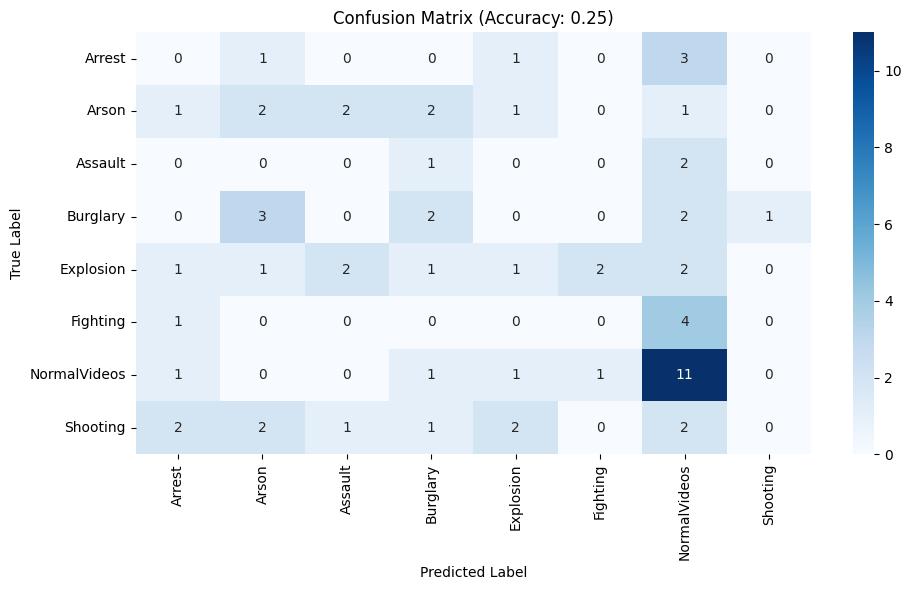

In [29]:
import torch
import torch.nn as nn
from transformers import AutoModel
from torch.optim import AdamW
from torch.nn import CrossEntropyLoss
from sklearn.utils.class_weight import compute_class_weight
import pandas as pd
import numpy as np

# Final best config
best_params = {
    'nhead': 4,
    'dropout': 0.3,
    'ff_dim': 1024,
    'label_smoothing': 0.1,
    'lr_head': 5e-5,
    'lr_vit': 5e-6
}

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

# final model class
class DINOv2_Transformer(nn.Module):
    def __init__(self, model_name='facebook/dinov2-base', hidden_dim=768, num_classes=8,
                 num_heads=4, ff_dim=1024, dropout=0.3):
        super().__init__()

        self.vit = AutoModel.from_pretrained(model_name)
        for name, param in self.vit.named_parameters():
            if "encoder.layer.11" in name or "layernorm" in name:
                param.requires_grad = True
            else:
                param.requires_grad = False
        self.vit.train()

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=hidden_dim,
            nhead=num_heads,
            dim_feedforward=ff_dim,
            dropout=dropout,
            batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=1)

        self.temporal_query = nn.Linear(hidden_dim, 1)
        self.norm = nn.LayerNorm(hidden_dim)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):  # x: (B, T, 3, 224, 224)
        B, T, C, H, W = x.shape
        x = x.view(B * T, C, H, W)
        vit_out = self.vit(pixel_values=x).last_hidden_state[:, 0]
        x_seq = vit_out.view(B, T, -1)
        x_encoded = self.transformer_encoder(x_seq)
        attn_weights = torch.softmax(self.temporal_query(x_encoded).squeeze(-1), dim=1)
        x_weighted = (x_encoded * attn_weights.unsqueeze(-1)).sum(dim=1)
        x_pooled = self.norm(x_weighted)
        return self.fc(self.dropout(x_pooled))

# final model start
model = DINOv2_Transformer(
    num_heads=best_params['nhead'],
    ff_dim=best_params['ff_dim'],
    dropout=best_params['dropout']
).to(DEVICE)

# class weight computation
all_labels = []
for _, label in train_dataset:
    if isinstance(label, torch.Tensor) and label.ndim > 1:
        label = torch.argmax(label).item()
    elif isinstance(label, torch.Tensor):
        label = label.item()
    all_labels.append(label)

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.arange(len(CLASS_NAMES)),
    y=all_labels
)
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(DEVICE)

# criterion
criterion = CrossEntropyLoss(
    weight=class_weights_tensor,
    label_smoothing=best_params['label_smoothing']
)

# optimiser
vit_params, head_params = [], []
for name, param in model.named_parameters():
    if param.requires_grad:
        (vit_params if "vit" in name else head_params).append(param)

optimizer = AdamW([
    {"params": vit_params, "lr": best_params['lr_vit']},
    {"params": head_params, "lr": best_params['lr_head']}
], weight_decay=0.01)

# training loop
best_test_loss = float('inf')
early_stop_counter = 0
patience = 5
max_epochs = 30
log = []

for epoch in range(max_epochs):
    model.train()
    running_loss = 0.0
    for x, y in train_loader:
        x, y = x.to(DEVICE), y.to(DEVICE)
        optimizer.zero_grad()
        logits = model(x)
        loss = criterion(logits, y)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        running_loss += loss.item()

    avg_train_loss = running_loss / len(train_loader)

    train_loss, train_acc, train_auc = evaluate(model, train_loader, criterion)
    test_loss, test_acc, test_auc = evaluate(model, test_loader, criterion)

    print(f"Epoch {epoch+1} | Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f}, AUC: {train_auc:.4f} | "
          f"Test Loss: {test_loss:.4f}, Acc: {test_acc:.4f}, AUC: {test_auc:.4f}")

    log.append({
        'epoch': epoch + 1,
        'train_loss': train_loss,
        'train_acc': train_acc,
        'train_auc': train_auc,
        'test_loss': test_loss,
        'test_acc': test_acc,
        'test_auc': test_auc
    })

    if test_loss < best_test_loss:
        best_test_loss = test_loss
        early_stop_counter = 0
        torch.save(model.state_dict(), "best_final_model.pt")
        print("Model saved.")
    else:
        early_stop_counter += 1
        if early_stop_counter >= patience:
            print("Early stopping triggered.")
            break


pd.DataFrame(log).to_csv("final_training_log.csv", index=False)
print("Training log saved to final_training_log.csv")

# evaluation
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Load best model
model.load_state_dict(torch.load("best_final_model.pt"))
model.eval()

y_true, y_pred = [], []

with torch.no_grad():
    for x, y in test_loader:
        x = x.to(DEVICE)
        logits = model(x)
        preds = torch.argmax(logits, dim=1).cpu().numpy()

        if y.ndim > 1:
            y = torch.argmax(y, dim=1)
        y_true.extend(y.cpu().numpy())
        y_pred.extend(preds)

# Accuracy
acc = accuracy_score(y_true, y_pred)
print(f"\n Final Test Accuracy: {acc:.4f}")

# Classification report
print("\n Classification Report:")
print(classification_report(y_true, y_pred, target_names=CLASS_NAMES))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES)
plt.title(f"Confusion Matrix (Accuracy: {acc:.2f})")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()




